In [1]:
import os
os.environ["FORCE_MEM_EFFICIENT_ATTN"] = "1"

import torch
import argparse
import torchvision.transforms as T
from deepfloyd_if.script_utils import create_guidance_model, add_adapter_for_guidance_model
import copy
from guided_diffusion.multi_expert_helper import MultiExpertWrapper
from deepfloyd_if.modules import IFStageI, IFStageII, StableStageIII, T5Embedder
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
from deepfloyd_if.pipelines import dream

FORCE_MEM_EFFICIENT_ATTN= 1 @UNET:QKVATTENTION


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


# Create arguments
Configuring arguments for code. Please set arguments that are appropriate for your environment.
- `guidance_model_path`: checkpoint file paths of fine-tuned ppap-midas models.
- `gamma`, `lora_alpha`: hyperparameters of PPAP model.
- `hr_token`: hugging face token for accessing deepfloyd-if models

In [2]:
def create_args():
    CKPT_BASE_PATH = "/shared/hyojun/ppap/deepfloyd_midas"
    args = argparse.Namespace(
        guidance_model_path=[
            f"{CKPT_BASE_PATH}/0_max5.ckpt",
            f"{CKPT_BASE_PATH}/1_max5.ckpt",
            f"{CKPT_BASE_PATH}/2_max5.ckpt",
            f"{CKPT_BASE_PATH}/3_max5.ckpt",
            f"{CKPT_BASE_PATH}/4_max5.ckpt",
        ],
        hf_token=None,
        gamma=16,
        lora_alpha=8,
    )
    return args

args = create_args()

# Load DeepFloyd-IF

In [3]:
if args.hf_token:
    from huggingface_hub import login
    login(token=args.hf_token)

if_I = IFStageI('IF-I-L-v1.0', device="cuda")
if_II = IFStageII('IF-II-M-v1.0', device="cuda")
if_III = StableStageIII('stable-diffusion-x4-upscaler', device="cuda")
t5 = T5Embedder(device="cuda")

/root/anaconda3/envs/ppap/lib/python3.8/site-packages/huggingface_hub/file_download.py:1104: FutureWarning: The `force_filename` parameter is deprecated as a new caching system, which keeps the filenames as they are on the Hub, is now in place.
  warnings.warn(
Keyword arguments {'token': None} are not expected by StableDiffusionUpscalePipeline and will be ignored.


# Load PPAP-Midas

In [4]:
original_model = create_guidance_model(task_name="depth")
original_model.to("cuda")
original_model.eval()

adapter_model = add_adapter_for_guidance_model(task_name="depth",
                                                   model=copy.deepcopy(original_model),
                                                   lora_alpha=args.lora_alpha,
                                                   gamma=args.gamma
                                   )

models = []
for ckpt_path in args.guidance_model_path:
    print(f"load {ckpt_path}")
    m, u = adapter_model.load_state_dict(torch.load(ckpt_path), strict=False)
    print("missing keys", m)
    print("unexpected keys", u)
    adapter_model.eval()
    adapter_model.to("cuda")
    models.append(copy.deepcopy(adapter_model))

model = MultiExpertWrapper(models, len(args.guidance_model_path), 1000)
normalize = T.Compose([
    T.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        )])

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Non-trainable parameters: 21243072
Trainable parameters: 1452961
Ratio: 0.07341853716737617
load /shared/hyojun/ppap/deepfloyd_midas/0_max5.ckpt
missing keys []
unexpected keys []
load /shared/hyojun/ppap/deepfloyd_midas/1_max5.ckpt
missing keys []
unexpected keys []
load /shared/hyojun/ppap/deepfloyd_midas/2_max5.ckpt
missing keys []
unexpected keys []
load /shared/hyojun/ppap/deepfloyd_midas/3_max5.ckpt
missing keys []
unexpected keys []
load /shared/hyojun/ppap/deepfloyd_midas/4_max5.ckpt
missing keys []
unexpected keys []


# Load base image for extracting target depth
Please choose the base image and set as:
```
with open(Image2) as img:
```

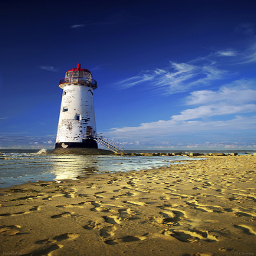

In [9]:
Image1 = "asset/ILSVRC2012_val_00011022.JPEG"
Image2 = "asset/FFHQ_example.png"
Image3 = "asset/ILSVRC2012_val_00027250.JPEG"

with Image.open(Image1) as img:
    img = img.convert("RGB")
img_for_depth = torchvision.transforms.Resize((256, 256))(T.ToTensor()(img)).unsqueeze(0).cuda()
torchvision.transforms.functional.to_pil_image(img_for_depth[0])

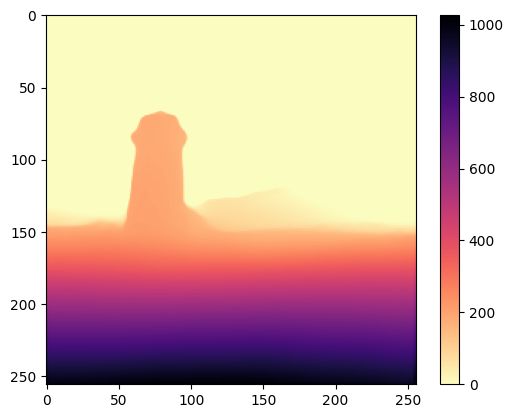

In [10]:
with torch.no_grad():
    depth_img = original_model(normalize(img_for_depth))
plt.imshow(depth_img.permute(1,2,0).cpu(), cmap="magma_r")
plt.colorbar()

# PPAP Midas guidance for unconditional DeepFloyd-IF

  0%|          | 0/185 [00:00<?, ?it/s]

loss tensor(-0.0526, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0686, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.1307, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0511, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0108, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0400, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0024, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0112, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0018, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0018, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0016, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0446, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0022, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0022, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0016, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0015, device='cuda:0', grad_fn=<NegBackward0>)
loss ten

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

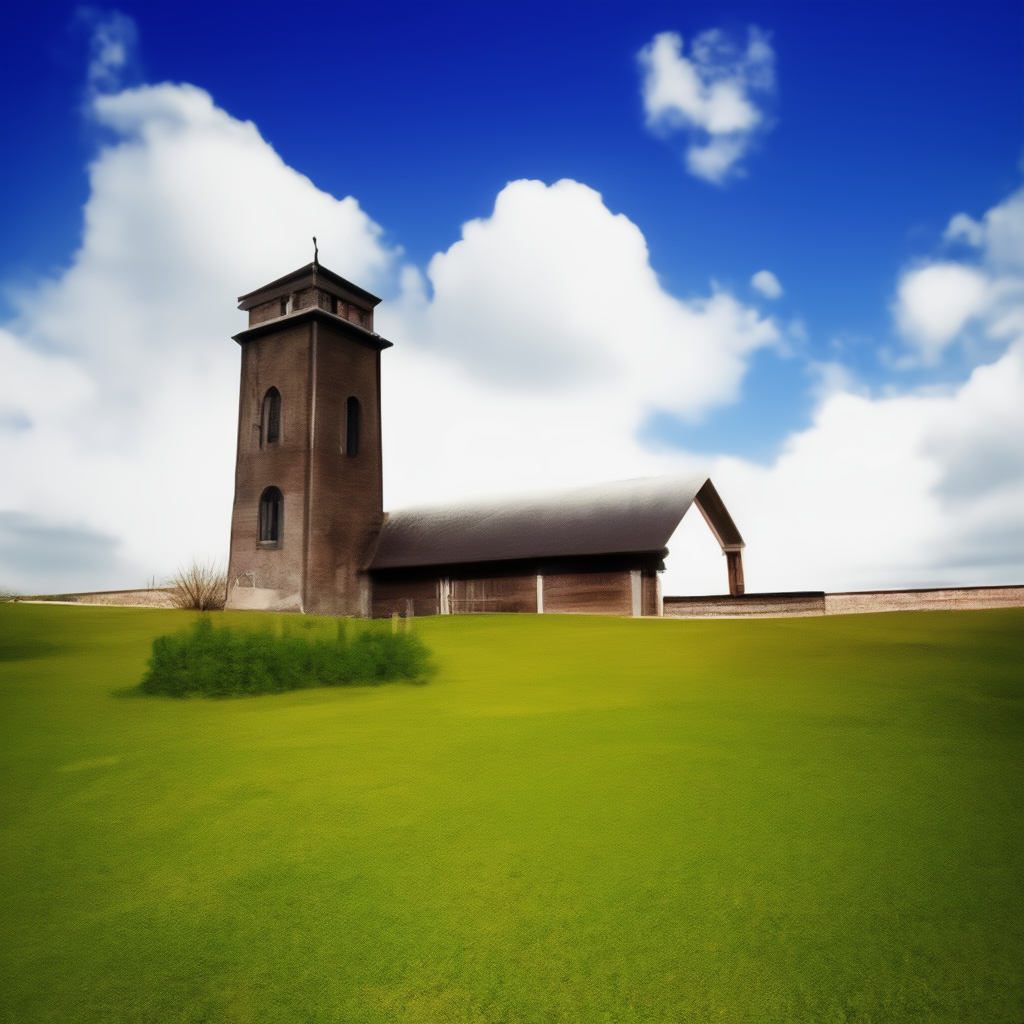

In [11]:
GUIDANCE_SCALE = 0.4
def normalize(depth):
    depth = (depth - depth.min())
    depth = depth / depth.max() + 1e-7
    return depth

def guidance_fn_with_midas(x, t, **model_kwargs):
    target = normalize(depth_img)
    with torch.enable_grad():
        with torch.cuda.amp.autocast():
            x_in = x.detach()[:len(x) // 2].requires_grad_(True)
            out_depth = model(x_in, t)
            out_depth = normalize(out_depth)
            loss = - torch.nn.MSELoss()(out_depth, target)
            print("loss", loss)
        (loss* 100000).backward()
        grad = x_in.grad / 100000
    return grad.detach(), GUIDANCE_SCALE

with torch.no_grad():
    result = dream(
        t5=t5, if_I=if_I, if_II=if_II, if_III=if_III,
        prompt=["prompt"] * 1,
        seed=42,
        if_I_kwargs={
            "guidance_scale": 0.0,
            "sample_loop": "ddpm",
            "sample_timestep_respacing": "smart185",
            "guidance_fn": guidance_fn_with_midas
        },
        if_II_kwargs={
            "guidance_scale": 0.0,
            "sample_timestep_respacing": "25",
        },
        if_III_kwargs={
            "guidance_scale": 0.0,
            "noise_level": 20,
            "sample_timestep_respacing": "25",
        },
        disable_watermark=True
    )
result["III"][0]

# PPAP Midas guidance for text-to-image DeepFloyd-IF

  0%|          | 0/185 [00:00<?, ?it/s]

loss tensor(-0.0526, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0717, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.1330, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0427, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0084, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0069, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0210, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0215, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0151, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0110, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0053, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0034, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0250, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0030, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0031, device='cuda:0', grad_fn=<NegBackward0>)
loss tensor(-0.0021, device='cuda:0', grad_fn=<NegBackward0>)
loss ten

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

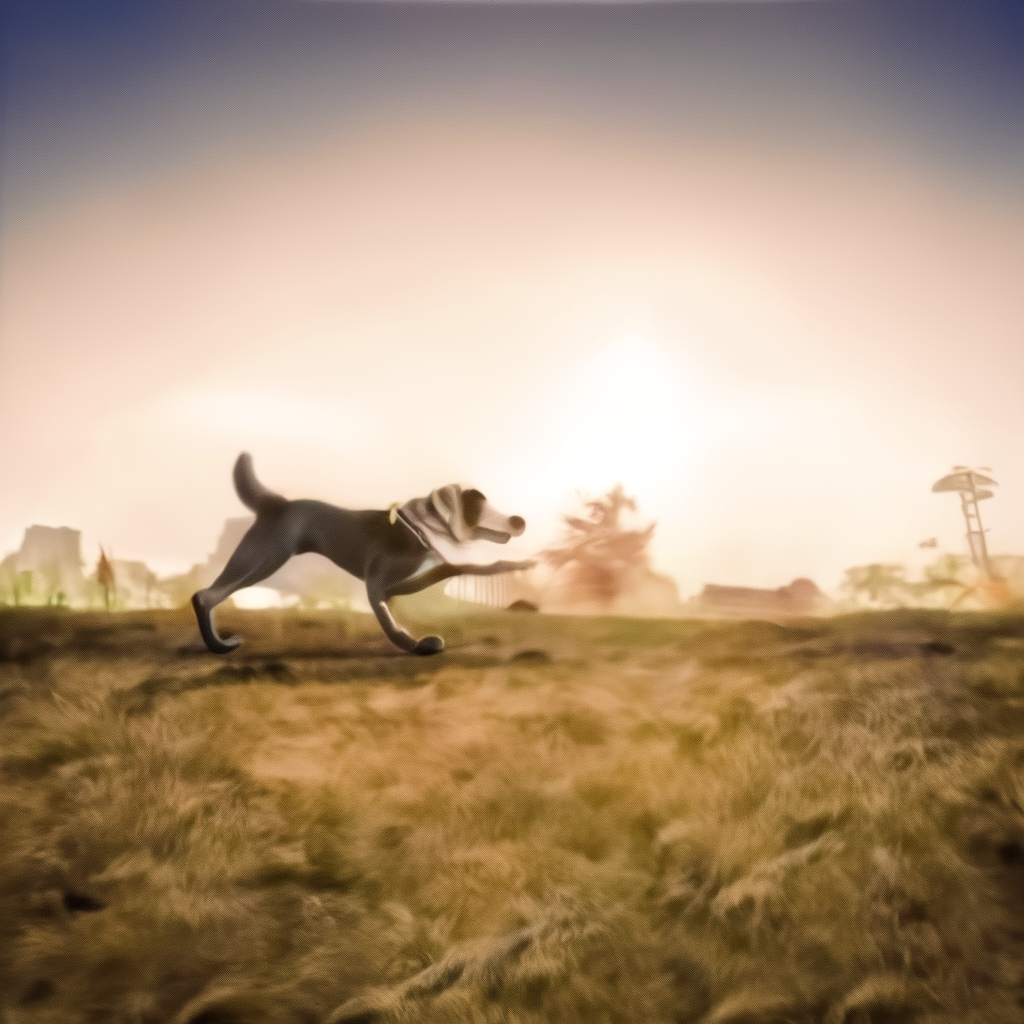

In [12]:
prompt = "A Dog"
GUIDANCE_SCALE = 0.4

def normalize(depth):
    depth = (depth - depth.min())
    depth = depth / depth.max() + 1e-7
    return depth

def guidance_fn_with_midas(x, t, **model_kwargs):
    target = normalize(depth_img)
    with torch.enable_grad():
        with torch.cuda.amp.autocast():
            x_in = x.detach()[:len(x) // 2].requires_grad_(True)
            out_depth = model(x_in, t)
            out_depth = normalize(out_depth)
            loss = - torch.nn.MSELoss()(out_depth, target)
            print("loss", loss)
        (loss* 100000).backward()
        grad = x_in.grad / 100000
    return grad, GUIDANCE_SCALE

with torch.no_grad():
    result = dream(
        t5=t5, if_I=if_I, if_II=if_II, if_III=if_III,
        prompt=[prompt] * 1,
        seed=42,
        if_I_kwargs={
            "guidance_scale": 3.0,
            "sample_loop": "ddpm",
            "sample_timestep_respacing": "smart185",
            "guidance_fn": guidance_fn_with_midas
        },
        if_II_kwargs={
            "guidance_scale": 7.0,
            "sample_timestep_respacing": "25",
        },
        if_III_kwargs={
            "guidance_scale": 9.0,
            "noise_level": 20,
            "sample_timestep_respacing": "25",
        },
        disable_watermark=True
    )
result["III"][0]